In [154]:
# Dataset: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(54312);

In [592]:
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

chars = sorted(list(set(text)))
stoi = { ch:i for i, ch in enumerate(chars)} # string to index map
itos = { i:ch for i, ch in enumerate(chars)} # index to string map
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [698]:
# Hyperparameters
# ------------------------
SL = 20               # Sequence length
BS = 32               # batch size
emb_sz = 64           # embedding size
vocab_sz = len(chars) # Vocab size
P = 0.2               # Dropout strength
head_size = 128       # Single attention head size
n_head = 4            # Num of heads in multi-head self attention
n_layers = 1          # Num of Blocks in BobNet
# ------------------------

train_split = 0.1     # % of data to use in train split 

# ------------------------

In [699]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data)*train_split) # using 90% as training set
Xtr = data[:n]
val_data = data[n:]

# Build dataset
def get_batch(split, seq_len=SL):
  data = Xtr if split == 'train' else val_data
  idx = torch.randint(0, len(data)-seq_len, size=(BS,))
  x = torch.stack([data[i  :i+seq_len  ] for i in idx])
  y = torch.stack([data[i+1:i+seq_len+1] for i in idx])
  return x,y

In [700]:
xb, yb = get_batch('train')
xb.shape, yb.shape

(torch.Size([32, 20]), torch.Size([32, 20]))

In [701]:
## Self Attention (Decoder)
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key   = nn.Linear(emb_sz, head_size, bias=False)
    self.query = nn.Linear(emb_sz, head_size, bias=False)
    self.value = nn.Linear(emb_sz, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(SL, SL)))
    self.dropout = nn.Dropout(P)

  def forward(self, x):
    # X = B,T,C ; where T is SL and C is emb_sz
    B,T,C = x.shape
    q = self.query(x) # (B,T,hs)
    k = self.key(x)   # (B,T,hs)
    wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B,T,hs) @ (B,hs,T) -> (B,T,T)
    wei = wei.masked_fill_(self.tril[:T, :T]==0, float('-inf')) # (B,T,T)
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    v = self.value(x) # (B,T,hs)
    out = wei @ v # (B,T,HS)
    return out


## Multi-head Self attention
class MultiHeadAttention(nn.Module):
  def __init__(self, n_head, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
    self.linear = nn.Linear(head_size * n_head, emb_sz)
    self.dropout = nn.Dropout(P)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.linear(out)) # B,T,HS @ B,HS,HS
    return out


## Helpers
class FeedForward(nn.Module):
  def __init__(self, emb_sz):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(emb_sz, 4*emb_sz),
      nn.LayerNorm(4*emb_sz),
      nn.ReLU(),
      nn.Linear(4*emb_sz, emb_sz),
      nn.Dropout(P)
    )

  def forward(self, x):
    out = self.net(x)
    return out


## Transformer
class Block(nn.Module):
  def __init__(self, n_head, emb_sz):
    super().__init__()
    assert emb_sz % n_head == 0
    head_size = emb_sz // n_head
    self.sa = MultiHeadAttention(n_head, head_size) # B,T,HS
    self.ff =   FeedForward(emb_sz)
    self.ln1 = nn.LayerNorm(emb_sz)
    self.ln2 = nn.LayerNorm(emb_sz)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ff(self.ln2(x))
    return x


class bobGenerator(nn.Module):
  def __init__(self):
    super().__init__()
    self.tok_emb = nn.Embedding(vocab_sz, emb_sz)
    self.pos_emb = nn.Embedding(SL, emb_sz)
    self.blocks = nn.Sequential(*[Block(n_head, emb_sz) for _ in range(n_layers)])
    self.lnorm = nn.LayerNorm(emb_sz)
    self.lout = nn.Linear(emb_sz, vocab_sz)
    # fixing initializations
    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias) * .001
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, xb, target=None):
    B,T = xb.shape
    tok_emb = self.tok_emb(xb) # B,T,C
    pos_emb = self.pos_emb(torch.arange(T)) # T,C
    x = tok_emb + pos_emb
    x = self.blocks(x)
    x = self.lnorm(x)
    logits =  self.lout(x)

    if target is None:
      loss = None
    else:
      B, T, C = logits.shape
      x = logits.view(B*T,C)
      y = yb.view(B*T)
      loss = F.cross_entropy(x, y)
    return logits, loss
  
  @torch.no_grad()
  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      i = idx[:, -SL:]
      logits, _ = self(i)
      logits = logits[:, -1, :] # B,T,C -> B,C
      probs = logits.softmax(-1)
      next_idx = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_idx), dim=1)
    return idx.squeeze()

In [702]:
bob = bobGenerator()
model = bob
print(sum([p.nelement() for p in model.parameters()]), "parameters")

60097 parameters


In [703]:
epoch = 1000
interval = 100    # run val per x epoch
eval_iters = 200  # run val per x data
learning_rate = 3e-4
lossi = []
vlossi = []

optim = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def split_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      _, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out['train'], out['val']

In [704]:
for i in range(epoch):
  # mini-batch
  xb,yb = get_batch('train')
  logits, loss = model(xb, yb)
  
  # backward
  optim.zero_grad(set_to_none=True)
  loss.backward()
  
  # step
  optim.step()
  
  # train-valid split testing (sometimes)
  if i % interval == 0 or i == epoch-1:
    tloss, vloss = split_loss()
    # print(f"epoch {i:7d}/{epoch:7d} | loss: {loss:7.4f} | perp: {(loss.exp().item()):7.4f}")
    print(f"epoch {i:7d}/{epoch:7d} | loss: {tloss:7.4f} | perp: {(loss.exp().item()):7.4f} | loss: {vloss:7.4f}")

  # track
  lossi.append(loss.item())
  vlossi.append(vloss.item())

epoch       0/   1000 | loss:  4.1380 | perp: 65.7615 | loss:  4.1375
epoch     100/   1000 | loss:  3.5883 | perp: 20.2983 | loss:  3.5706
epoch     200/   1000 | loss:  3.7387 | perp: 14.2765 | loss:  3.7135
epoch     300/   1000 | loss:  4.0374 | perp: 11.8960 | loss:  4.0103
epoch     400/   1000 | loss:  4.3180 | perp: 11.4378 | loss:  4.2919
epoch     500/   1000 | loss:  4.4227 | perp: 10.8336 | loss:  4.3745
epoch     600/   1000 | loss:  4.5105 | perp: 10.4199 | loss:  4.4543
epoch     700/   1000 | loss:  4.8102 | perp:  9.8730 | loss:  4.7482
epoch     800/   1000 | loss:  4.7283 | perp:  8.9646 | loss:  4.6756
epoch     900/   1000 | loss:  5.1240 | perp:  7.8907 | loss:  5.0745
epoch     999/   1000 | loss:  4.9424 | perp:  9.0610 | loss:  4.8774


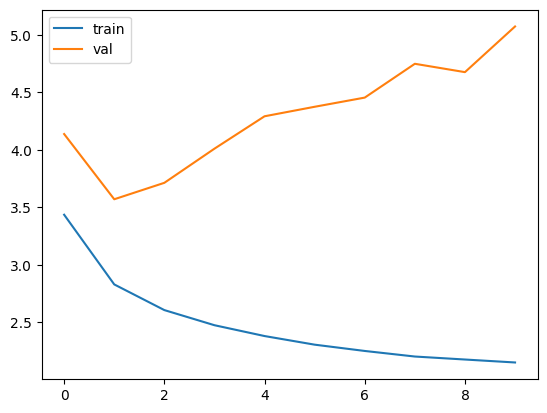

In [705]:
legends = ['train', 'val']
plt.plot(torch.tensor(lossi).view(-1, 100).mean(-1), label='train');
plt.plot(torch.tensor(vlossi).view(-1, 100).mean(-1), label='val');
plt.legend(legends)
plt.show()

In [713]:
idx = torch.zeros((1, 1), dtype=torch.long) # instead of B,T -- 1,1
# we are predicting (for each seq) the next token

# bob is speaking
bob_lang = bob.generate(idx, max_new_tokens=20).tolist()
print(decode(bob_lang))


tour This thary
We I
